In [1]:
import numpy as np
import matplotlib.pyplot as plt
import irf
from irf.ensemble import wrf as rfc
from irf.utils import (
    get_prevalent_interactions,
    visualize_impurity_decrease,
    visualize_prevalent_interactions,
    get_filtered_feature_paths
)
import rpy2.robjects as robjects
from irf.irf_jupyter_utils import draw_tree

# Simulate the settings in the signed iRF paper

## Simulation 1: and rule

In [2]:
def f(X):
    t = 1 - 0.1 ** .25
    X1 = X[:, [45, 49, 63, 74]]
    q = np.quantile(X1, t1, axis=0)
    return 0.8 * np.alltrue(X1 > q , axis=1)

$
P(Y = 1) = 0.8 \cdot 
1(X_{45} > t_1, X_{49} > t_1, X_{63} > t_1, X_{74} > t_1) 
$
where $t_1 = 1 - 0.1^{1/4}$.

In [3]:
def load_data(i=0):
    robjects.r['load']("../../signediRF/data/enhancer_sim_and.Rdata")
    raw = np.array(robjects.r['data'][i])
    len_train_id = int(raw[-1])
    train_id = raw[-(len_train_id + 1):-1].astype(int) - 1
    
    X = np.array(robjects.r['data'][i])[:7809 * 80].reshape((80, 7809)).T
    y = np.array(robjects.r['data'][i])[7809*80:7809*81]
    return X[train_id], y[train_id]

In [4]:
X, y = load_data(19)

In [5]:
rf = rfc()

In [6]:
rf.fit(X, y, keep_record=False)

wrf(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini',
    max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
    min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
    n_jobs=None, oob_score=False, random_state=None, verbose=0,
    warm_start=False)

<BarContainer object of 80 artists>

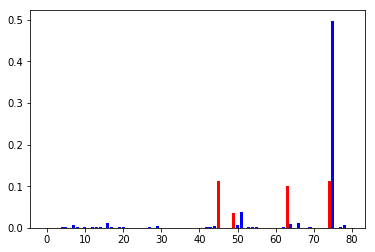

In [7]:
color = ['b' for x in range(80)]
for x in [45, 49, 63, 74]:
    color[x] = 'r'
plt.bar(np.arange(80), rf.feature_importances_, color=color)

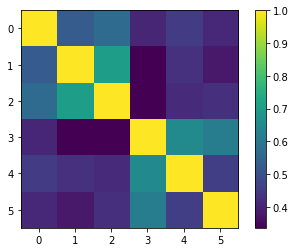

In [8]:
# look at the correlation between y_train and different features
plt.imshow(np.corrcoef(np.vstack([X[:,[45, 49, 63, 74, 75]].T, y.T])))
plt.colorbar()
plt.show()

### Observation: 75 explains 45, 49, 63 better.

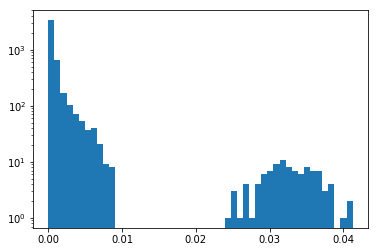

In [9]:
#visualize the impurity decrease of the rf model
visualize_impurity_decrease(rf, xscale='linear', bins=50)

In [10]:
rf.n_paths

4879

In [14]:
#preprocess compute the prevalence
prevalence = get_prevalent_interactions(
    rf,
    impurity_decrease_threshold=0.001,
    min_support=100,
    signed=True,
    weight_scheme="samplesize"
)

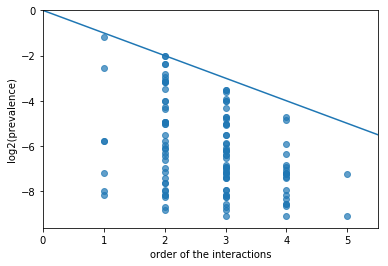

In [12]:
#visualize the interaction plot
visualize_prevalent_interactions(prevalence=prevalence)

In [15]:
list(prevalence.items())[:20]

[(((74, 'L'), (75, 'L')), 0.873901980874317),
 (((63, 'L'), (74, 'R'), (75, 'L')), 0.037107240437158455),
 (((45, 'R'), (49, 'R'), (63, 'R'), (74, 'R'), (75, 'L')),
  0.0028551912568306075),
 (((45, 'R'), (63, 'R'), (74, 'R'), (75, 'L')), 0.008724385245901708),
 (((45, 'R'), (63, 'R'), (74, 'R'), (75, 'R')), 0.006774248633879823),
 (((45, 'R'), (74, 'R'), (75, 'R')), 0.023056693989071387),
 (((45, 'R'), (51, 'L'), (63, 'R'), (74, 'R'), (75, 'R')),
  0.0017281420765027304),
 (((45, 'L'), (63, 'R'), (74, 'R'), (75, 'L')), 0.0055771857923497285),
 (((74, 'R'), (75, 'L')), 0.0682137978142069),
 (((45, 'R'), (49, 'R'), (74, 'R'), (75, 'L')), 0.004381830601092913),
 (((45, 'R'), (51, 'L'), (74, 'R'), (75, 'R')), 0.004091530054644819),
 (((45, 'R'), (63, 'R'), (74, 'R')), 0.015498633879781615),
 (((63, 'R'), (74, 'R'), (75, 'L')), 0.01528688524590177),
 (((49, 'L'), (74, 'R'), (75, 'L')), 0.012546106557377082),
 (((45, 'R'), (49, 'R'), (63, 'R'), (74, 'R')), 0.002908128415300554),
 (((45, 'R'

## Simulation 2: OR rule

In [222]:
def f(X):
    t1 = 1 - 0.1 ** .25
    t2 = 1 - 0.25 ** .25
    X1 = X[:, [45, 74]]
    q11 = np.quantile(X1, t1, axis=0)
    q12 = np.quantile(X1, 1 - t2, axis=0)
    X2 = X[:, [49, 63]]
    q21 = np.quantile(X2, 1 - t1, axis=0)
    q22 = np.quantile(X2, t2, axis=0)
    return 0.4 * np.logical_or(
        np.alltrue(X1 > q11 , axis=1) * np.alltrue(X2 <= q21 , axis=1),
        np.alltrue(X1 <= q12, axis=1) * np.alltrue(X2 > q22, axis=1)
    )

In [13]:
def f(X):
    t1 = 1 - 0.1 ** .25
    t2 = 1 - 0.25 ** .25
    X1 = X[:, [45, 74]]
    q11 = np.quantile(X1, t1, axis=0)
    q12 = np.quantile(X1, 1 - t2, axis=0)
    X2 = X[:, [49, 63]]
    q21 = np.quantile(X2, 1 - t1, axis=0)
    q22 = np.quantile(X2, t2, axis=0)
    print(q12[1])
    return (
        np.alltrue(X[:, [45]] <= q12[0], axis=1) * np.alltrue(X2 > q22, axis=1)
    )

$
P(Y = 1) = 0.4 \cdot 
\left(
1(X_{45} > t_1, X_{74} > t_1, X_{49} < 1 - t_1, X_{63} < 1 - t_1) + 
1(X_{49} > t_2, X_{63} > t_2, X_{45} < 1 - t_2, X_{74} < 1 - t_2)
\right)
$
where $t_1 = 1 - 0.1^{1/4}$ and $t_2 = 1 - 0.25^{1/4}$.

0.0


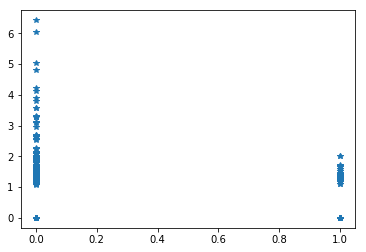

In [14]:
plt.plot(f(X), X[:, 74], '*')

0.0


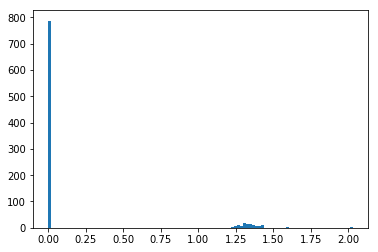

In [18]:
plt.hist(X[f(X) > 0.1, 74],100)
plt.show()

In [2]:
def load_data(i=0):
    robjects.r['load']("../../signediRF/data/enhancer_sim_or.Rdata")
    raw = np.array(robjects.r['data'][i])
    len_train_id = int(raw[-1])
    train_id = raw[-(len_train_id + 1):-1].astype(int) - 1
    
    X = np.array(robjects.r['data'][i])[:7809 * 80].reshape((80, 7809)).T
    y = np.array(robjects.r['data'][i])[7809*80:7809*81]
    return X[train_id], y[train_id]
    #return X, y

In [5]:
X, y = load_data(1)

In [239]:
rf = rfc()

In [240]:
rf.fit(X, y, keep_record=False)

wrf(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini',
    max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
    min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
    n_jobs=None, oob_score=False, random_state=None, verbose=0,
    warm_start=False)

<BarContainer object of 80 artists>

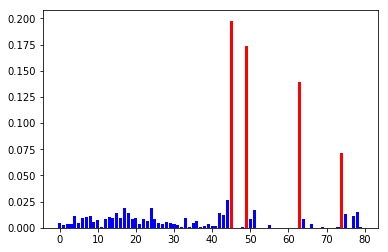

In [241]:
color = ['b' for x in range(80)]
for x in [45, 49, 63, 74]:
    color[x] = 'r'
plt.bar(
    np.arange(80),
    rf.feature_importances_,
    color = color,
)

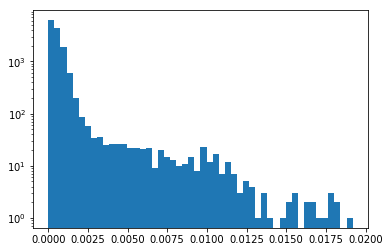

In [242]:
#visualize the impurity decrease of the rf model
visualize_impurity_decrease(rf, xscale='linear', bins=50)

In [243]:
#preprocess compute the prevalence
prevalence = get_prevalent_interactions(rf, impurity_decrease_threshold=1e-3, min_support=500, signed=True)

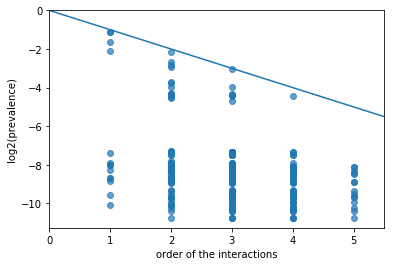

In [244]:
#visualize the interaction plot
visualize_prevalent_interactions(prevalence=prevalence)

In [245]:
#visualize find out the most prevalent interactions
list(prevalence.items())[:20]

[(((45, 'L'), (49, 'R'), (63, 'R')), 0.12132812500000285),
 (((45, 'L'), (63, 'R')), 0.22312500000000568),
 (((45, 'L'), (49, 'R'), (63, 'R'), (74, 'L')), 0.04662109375000061),
 (((63, 'R'),), 0.4559375000000147),
 (((63, 'L'),), 0.45593749999999855),
 (((45, 'R'), (63, 'L'), (74, 'R')), 0.06281249999999973),
 (((63, 'L'), (74, 'R')), 0.15421874999999952),
 (((49, 'R'), (63, 'R')), 0.13945312500000365),
 (((45, 'L'), (63, 'R'), (74, 'L')), 0.04880859375000063),
 (((49, 'R'), (63, 'R'), (74, 'L')), 0.04724609375000061),
 (((45, 'L'), (49, 'R')), 0.130390625000003),
 (((45, 'L'), (49, 'R'), (74, 'L')), 0.04662109375000061),
 (((49, 'L'), (63, 'L'), (74, 'R')), 0.03884765624999978),
 (((44, 'R'), (45, 'L'), (49, 'R'), (63, 'R'), (74, 'L')),
  0.0036398792266845595),
 (((24, 'R'), (45, 'L'), (49, 'R'), (63, 'R'), (74, 'L')),
  0.003571434020996093),
 (((45, 'L'),), 0.3198437500000083),
 (((24, 'L'), (45, 'L'), (49, 'R'), (63, 'R'), (74, 'L')),
  0.0031808090209960887),
 (((45, 'L'), (49, '

## Simulation 3: Add rule

$P(Y=1) = 0.4 \cdot (1(X_{49} > t, X_{53} > t, X_{63} > t) + 1(X_{45} > t, X_{74} > t, X_{77} > t))$ where t is the $1 - 0.1^{1/4}$ quantile.

In [246]:
def f(X):
    t = 1 - 0.1 ** .25
    X1 = X[:, [49, 53, 63]]
    q1 = np.quantile(X1, t, axis=0)
    X2 = X[:, [45, 74, 77]]
    q2 = np.quantile(X2, t, axis=0)
    return 0.4 * (np.alltrue(X1 > q1, axis=1) * 1.0 + np.alltrue(X2 > q2, axis=1))

In [247]:
def load_data(i=0):
    robjects.r['load']("../../signediRF/data/enhancer_sim_add.Rdata")
    raw = np.array(robjects.r['data'][i])
    len_train_id = int(raw[-1])
    train_id = raw[-(len_train_id + 1):-1].astype(int) - 1
    
    X = np.array(robjects.r['data'][i])[:7809 * 80].reshape((80, 7809)).T
    y = np.array(robjects.r['data'][i])[7809*80:7809*81]
    return X[train_id], y[train_id]

In [248]:
X, y = load_data(2)

In [249]:
rf = rfc()

In [250]:
rf.fit(X, y, keep_record=False)

wrf(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini',
    max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
    min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
    n_jobs=None, oob_score=False, random_state=None, verbose=0,
    warm_start=False)

<BarContainer object of 80 artists>

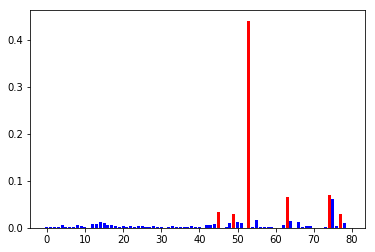

In [252]:
color = ['b' for x in range(80)]
for x in [49, 53, 63] + [45, 74, 77]:
    color[x] = 'r'
plt.bar(np.arange(80), rf.feature_importances_, color=color)

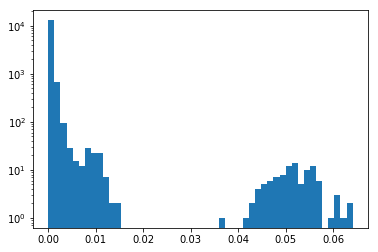

In [253]:
#visualize the impurity decrease of the rf model
visualize_impurity_decrease(rf, xscale='linear', bins=50)

In [254]:
#preprocess compute the prevalence
prevalence = get_prevalent_interactions(rf, impurity_decrease_threshold=0.001, min_support=2000, signed=True)

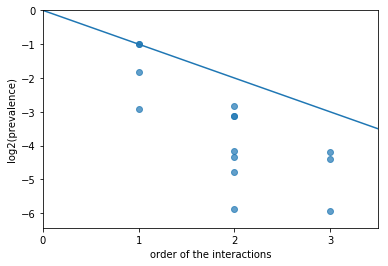

In [255]:
#visualize the interaction plot
visualize_prevalent_interactions(prevalence=prevalence)

In [256]:
#visualize find out the most prevalent interactions
list(prevalence.items())[:20]

[(((53, 'R'),), 0.5000000000000066),
 (((53, 'L'),), 0.49999999999999734),
 (((53, 'R'), (63, 'R'), (74, 'L')), 0.05504150390624994),
 (((53, 'R'), (74, 'L')), 0.14122070312500046),
 (((53, 'R'), (63, 'R'), (75, 'L')), 0.047090606689453016),
 (((53, 'R'), (63, 'R')), 0.11450439453125011),
 (((53, 'R'), (75, 'L')), 0.11356521606445315),
 (((74, 'R'),), 0.28190429687499846),
 (((49, 'R'), (53, 'R'), (63, 'R')), 0.016365509033203062),
 (((63, 'R'), (74, 'L')), 0.055354003906249935),
 (((63, 'R'), (75, 'L')), 0.049434356689453014),
 (((49, 'R'), (53, 'R')), 0.03641189575195295),
 (((63, 'R'),), 0.13177001953124948),
 (((49, 'R'), (63, 'R')), 0.01699050903320306)]